<a href="https://colab.research.google.com/github/ramreddy-physics/Portfolio-Optimization-Notebooks/blob/main/predictive_weights_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yfinance as yf
from torch.utils.data import DataLoader, TensorDataset

In [10]:
# Importing Libraries

# Data handling and statistical analysis 
import pandas as pd
# from pandas_datareader import data
import numpy as np
from scipy import stats

# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
# Financial data 
import quantstats as qs
import yfinance as yf

# Linear Regression Model
from sklearn.linear_model import LinearRegression

# Datetime and hiding warnings 
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [69]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'DAL', 'V', 'GE', 'SPGI', 'MU', 'DIS', 'LLY', 'META', 'TSLA', 'NFLX', 'PYPL', 'JPM', 'GS', 'C', 'BAC']
returns = { ticker: qs.utils.download_returns(ticker).loc['2017-07-01':'2024-07-01'] for ticker in tickers }

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [70]:
returns = pd.DataFrame(returns)
returns.head()

,AAPL,MSFT,GOOG,AMZN,NVDA,DAL,V,GE,SPGI,MU,DIS,LLY,META,TSLA,NFLX,PYPL,JPM,GS,C,BAC
Date,,,,,,,,,,,,,,,,,,,,
2017-07-03,-0.003611,-0.011026,-0.011037,-0.014814,-0.036179,0.005955,-0.004585,0.016290,-0.001849,-0.024113,0.011388,0.004860,-0.016890,-0.024861,-0.021685,-0.014906,0.014770,0.024245,0.020634,0.017312
2017-07-05,0.004111,0.013349,0.014476,0.018602,0.026699,0.004994,0.007070,-0.003643,0.012421,0.047014,-0.017030,0.000000,0.012868,-0.072401,0.009852,0.032911,0.010027,0.003344,0.002783,0.009724
2017-07-06,-0.009439,-0.007383,-0.005506,-0.006444,0.003006,0.000736,-0.008084,-0.038026,-0.007998,-0.013438,-0.021585,-0.013301,-0.010110,-0.055826,-0.009213,-0.020875,-0.003202,-0.005920,-0.011980,-0.008427
2017-07-07,0.010159,0.012979,0.013125,0.014112,0.022860,0.020048,0.007185,-0.006081,0.016672,0.003322,-0.000290,0.008456,0.017605,0.014215,0.026872,0.009351,0.005033,-0.006220,0.004140,0.004856
2017-07-10,0.006104,0.007486,0.011115,0.018094,0.047288,-0.011720,0.012457,-0.004207,0.000067,0.009934,0.002613,-0.000122,0.013603,0.009035,0.016580,0.017973,-0.007032,0.002486,-0.003829,0.002416


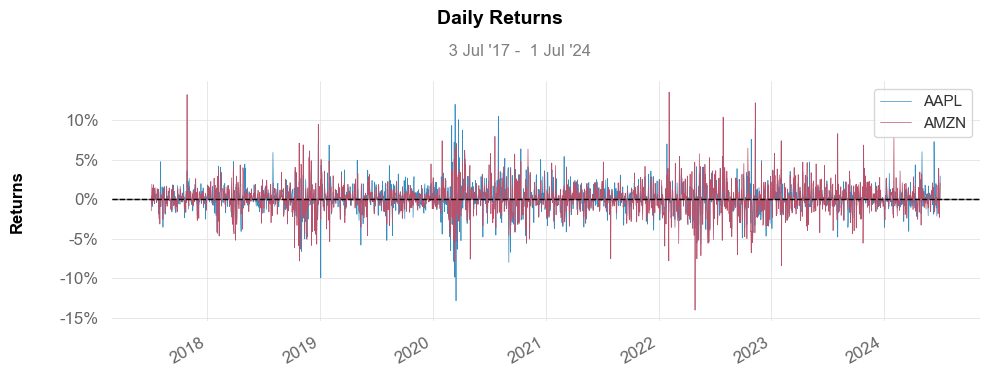

In [71]:
qs.plots.daily_returns(returns[['AAPL','AMZN']],benchmark=None)

In [72]:
#write a simple function to calculate the sharpe ratio of a portfolio
#inputs will be a dataframe of returns, a list of weights, and a risk free rate
#output will be the sharpe ratio of the portfolio

def annualized_sharpe(returns, 
                 risk_free_rate=0.05, 
                 weights=1):
    #form a 1d array by adding weighted log returns
    portfolio_returns = np.dot(returns, weights)
    #compute the excess portfolio returns
    excess_returns = portfolio_returns - risk_free_rate/252
    #compute the mean of the differential portfolio returns
    mean_excess_returns = np.mean(excess_returns)
    #calculate the portfolio volatility
    portfolio_volatility = np.std(excess_returns)
    #calculate the sharpe ratio
    annualized_sharpe_ratio = np.sqrt(252) * mean_excess_returns / portfolio_volatility
    return annualized_sharpe_ratio

In [73]:
for ticker in returns.columns:
    print(f'{ticker} Sharpe Ratio: {annualized_sharpe(returns[ticker])}')

AAPL Sharpe Ratio: 0.8324570258874343
MSFT Sharpe Ratio: 0.9134931572787611
GOOG Sharpe Ratio: 0.6511271459234601
AMZN Sharpe Ratio: 0.6139048168276039
NVDA Sharpe Ratio: 1.15833728905376
DAL Sharpe Ratio: 0.054609123458184944
V Sharpe Ratio: 0.5055578708809493
GE Sharpe Ratio: 0.14460703224740665
SPGI Sharpe Ratio: 0.5403020975653923
MU Sharpe Ratio: 0.5843532134263296
DIS Sharpe Ratio: -0.04629922081012082
LLY Sharpe Ratio: 1.170858871519923
META Sharpe Ratio: 0.5068002516490757
TSLA Sharpe Ratio: 0.7294440743293417
NFLX Sharpe Ratio: 0.6012304997429413
PYPL Sharpe Ratio: 0.10930473279329206
JPM Sharpe Ratio: 0.37238257055869683
GS Sharpe Ratio: 0.3347134983988744
C Sharpe Ratio: 0.010496249501689396
BAC Sharpe Ratio: 0.228702087559737


In [74]:
N = len(tickers)
weights = [1/N for _ in range(N)]
print(f'Equal Weights Portfolio Sharpe Ratio: {annualized_sharpe(returns, weights=weights)}')

Equal Weights Portfolio Sharpe Ratio: 0.7522338835378348


In [79]:
sharpe_ratios = pd.DataFrame({'ticker': tickers, 'sharpe_ratio': [annualized_sharpe(returns[ticker]) for ticker in tickers]})
sharpe_ratios = sharpe_ratios.sort_values('sharpe_ratio', ascending=False,ignore_index=True)
sharpe_ratios

,ticker,sharpe_ratio
0,LLY,1.170859
1,NVDA,1.158337
2,MSFT,0.913493
3,AAPL,0.832457
4,TSLA,0.729444
5,GOOG,0.651127
6,AMZN,0.613905
7,NFLX,0.601230
8,MU,0.584353
9,SPGI,0.540302


In [85]:
#create a dataframe of returns in descending order of sharpe ratio
ordered_returns = returns[sharpe_ratios['ticker']].dropna()

In [86]:
ordered_returns.head()

,LLY,NVDA,MSFT,AAPL,TSLA,GOOG,AMZN,NFLX,MU,SPGI,META,V,JPM,GS,BAC,GE,PYPL,DAL,C,DIS
Date,,,,,,,,,,,,,,,,,,,,
2017-07-03,0.004860,-0.036179,-0.011026,-0.003611,-0.024861,-0.011037,-0.014814,-0.021685,-0.024113,-0.001849,-0.016890,-0.004585,0.014770,0.024245,0.017312,0.016290,-0.014906,0.005955,0.020634,0.011388
2017-07-05,0.000000,0.026699,0.013349,0.004111,-0.072401,0.014476,0.018602,0.009852,0.047014,0.012421,0.012868,0.007070,0.010027,0.003344,0.009724,-0.003643,0.032911,0.004994,0.002783,-0.017030
2017-07-06,-0.013301,0.003006,-0.007383,-0.009439,-0.055826,-0.005506,-0.006444,-0.009213,-0.013438,-0.007998,-0.010110,-0.008084,-0.003202,-0.005920,-0.008427,-0.038026,-0.020875,0.000736,-0.011980,-0.021585
2017-07-07,0.008456,0.022860,0.012979,0.010159,0.014215,0.013125,0.014112,0.026872,0.003322,0.016672,0.017605,0.007185,0.005033,-0.006220,0.004856,-0.006081,0.009351,0.020048,0.004140,-0.000290
2017-07-10,-0.000122,0.047288,0.007486,0.006104,0.009035,0.011115,0.018094,0.016580,0.009934,0.000067,0.013603,0.012457,-0.007032,0.002486,0.002416,-0.004207,0.017973,-0.011720,-0.003829,0.002613


In [83]:
weights = np.array(range(1, N+1))
weights = weights/weights.sum()
weights

array([0.0047619 , 0.00952381, 0.01428571, 0.01904762, 0.02380952,
       0.02857143, 0.03333333, 0.03809524, 0.04285714, 0.04761905,
       0.05238095, 0.05714286, 0.06190476, 0.06666667, 0.07142857,
       0.07619048, 0.08095238, 0.08571429, 0.09047619, 0.0952381 ])

In [87]:
#compute annualized sharpe ratio of the portfolio with stocks weighted by their rank in the ordered returns dataframe
print(f'Rank Weighted Portfolio Sharpe Ratio: {annualized_sharpe(ordered_returns, weights=weights)}')

Rank Weighted Portfolio Sharpe Ratio: 0.45389499824052576


In [88]:
from scipy.optimize import minimize

In [140]:
#Find a set of weights, equivalently portfolio investment percentages in stock_symbols, which which maximizes a historical portfolio's annualized sharpe ratio subject to the following investment constraints
#1) Must invest at least 3% of capital into each index
#2) Cannot invest more than 35% of capital into a single index

def max_sharpe(returns, 
                    lower_bound=0.03, 
                    upper_bound=0.35, 
                    risk_free_rate=0.05):
    
    #number of assets
    n_assets = returns.shape[1]

    #Define an initial guess for asset weights (equal weights)
    initial_weights = np.array([1/n_assets for _ in range(n_assets)])

    #Define bounds for asset weights
    bounds = [(lower_bound, upper_bound) for _ in range(n_assets)]

    #Define weight constraints
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
            #   {'type': 'ineq', 'fun': lambda weights: min(weights)-lower_bound},
            #   {'type': 'ineq', 'fun': lambda weights: upper_bound-max(weights)})

    #Define the objective function
    def objective(x):
        return  1/annualized_sharpe(returns, weights=x, risk_free_rate=risk_free_rate)
    
    #Minimize the negative sharpe ratio
    result = minimize(objective, 
                      x0=initial_weights, 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=constraints)
    return {'weights': pd.DataFrame({'ticker': tickers, 'weight': result.x}), 
            'sharpe_ratio': 1/result.fun}

In [141]:
#compute the optimal weights for the portfolio with lower bound of 3% and upper bound of 35%
sharpe_3_35 = max_sharpe(returns)
print(f'Optimal Portfolio Sharpe Ratio: {sharpe_3_35["sharpe_ratio"]} achieved with the following weights:')
sharpe_3_35['weights']

Optimal Portfolio Sharpe Ratio: 1.1579363301043257 achieved with the following weights:


,ticker,weight
0,AAPL,0.030000
1,MSFT,0.030000
2,GOOG,0.030000
3,AMZN,0.030000
4,NVDA,0.144634
5,DAL,0.030000
6,V,0.030000
7,GE,0.030000
8,SPGI,0.030000
9,MU,0.030000


In [142]:
#compute the optimal weights for the portfolio with lower bound of 1% and upper bound of 50%
sharpe_1_50 = max_sharpe(returns, lower_bound=0.01, upper_bound=0.50)
print(f'Optimal Portfolio Sharpe Ratio: {sharpe_1_50["sharpe_ratio"]} achieved with the following weights:')
sharpe_1_50['weights']

Optimal Portfolio Sharpe Ratio: 1.421628320648274 achieved with the following weights:


,ticker,weight
0,AAPL,0.010000
1,MSFT,0.010000
2,GOOG,0.010000
3,AMZN,0.010000
4,NVDA,0.257529
5,DAL,0.010000
6,V,0.010000
7,GE,0.010000
8,SPGI,0.010000
9,MU,0.010000


In [143]:
#compute the optimal weights for the portfolio with lower bound of 1% and upper bound of 99%
sharpe_1_99 = max_sharpe(returns, lower_bound=0.01, upper_bound=0.99)
print(f'Optimal Portfolio Sharpe Ratio: {sharpe_1_99["sharpe_ratio"]} achieved with the following weights:')
sharpe_1_99['weights']

Optimal Portfolio Sharpe Ratio: 1.4231674885670154 achieved with the following weights:


,ticker,weight
0,AAPL,0.010000
1,MSFT,0.010000
2,GOOG,0.010000
3,AMZN,0.010000
4,NVDA,0.236833
5,DAL,0.010000
6,V,0.010000
7,GE,0.010000
8,SPGI,0.010000
9,MU,0.010000


In [139]:
#compute the optimal weights for the portfolio with lower bound of 0% and upper bound of 100%
sharpe_0_100 = max_sharpe(returns, lower_bound=0, upper_bound=1)
print(f'Optimal Portfolio Sharpe Ratio: {sharpe_0_100["sharpe_ratio"]} achieved with the following weights:')
sharpe_0_100['weights']

Optimal Portfolio Sharpe Ratio: 1.5029615226644775 achieved with the following weights:


,ticker,weight
0,AAPL,0.000000e+00
1,MSFT,3.433660e-17
2,GOOG,1.230816e-16
3,AMZN,0.000000e+00
4,NVDA,2.932969e-01
5,DAL,3.993344e-17
6,V,1.093601e-17
7,GE,0.000000e+00
8,SPGI,0.000000e+00
9,MU,1.787987e-17
